<a href="https://colab.research.google.com/github/AndreassOlsson/FastAI/blob/main/mid-level_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mid-level fastai API examples and walkthroughs

This notebook covers two varied examples of using the mid-level APIs of fastai. These exampels are meant to give a better understanding of the different data handling and learning steps in fastai library. In general, the more low-level these examples get, the more they will be applicable in other libraries aswell, since the concepts of DL are shared between all libraries.

https://docs.fast.ai/

# Imagenette

## Loading data with the mid-level API

Now let’s see how we can load the data with the medium-level API: we will learn about Transforms and Datasets. The beginning is the same as before: we download our data and get all our filenames:

In [ ]:
from fastai.vision.all import *
from fastai.data.all import *

In [ ]:
path = untar_data(URLs.IMAGENETTE_160)
fnames = get_image_files(path)

Every bit of transformation we apply to our raw items (here the filenames) is called a Transform in fastai. It’s basically a function with a bit of added functionality:

* it can have different behavior depending on the type it receives (this is called type dispatch)
* it will generally be applied on each element of a tuple

This way, when you have a Transform like resize, you can apply it on a tuple (image, label) and it will resize the image but not the categorical label (since there is no implementation of resize for categories). The exact same transform applied on a tuple (image, mask) will resize the image and the target, using bilinear interpolation on the image and nearest neighbor on the mask. This is how the library manages to always apply data augmentation transforms on every computer vision application (segmentation, point localization or object detection).

Additionally, a transform can have:

* a setup executed on the whole set (or the whole training set). This is how Categorize builds it vocabulary automatically.
* a decodes that can undo what the transform does for showing purposes (for instance Categorize will convert back an index into a category).

To open an image, we use the PILImage.create transform. It will open the image and make it of the fastai type PILImage:

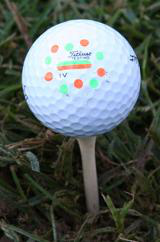

In [ ]:
im = PILImage.create(fnames[0])
im

In [ ]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

lbl_dict[parent_label(fnames[0])]

'golf ball'

To make them proper categories that are mapped to an index before being fed to the model, we need to add the Categorize transform. If we want to apply it directly, we need to give it a vocab (so that it knows how to associate a string with an int). We already saw that we can compose several transforms by using a Pipeline:

In [ ]:
tfm = Pipeline([parent_label, lbl_dict.__getitem__, Categorize(vocab = lbl_dict.values())])

In [ ]:
tfm.vocab[tfm(fnames[0])]

'golf ball'

Now to build our Datasets object, we need to specify:

* our raw items
* the list of transforms that builds our inputs from the raw items
* the list of transforms that builds our targets from the raw items
* the split for training and validation

We have everything apart from the split right now, which we can build this way:

In [ ]:
splits = GrandparentSplitter(valid_name='val')(fnames)

In [ ]:
print(splits[0][-3:])
print(splits[1][-3:])

[9466, 9467, 9468]
[13391, 13392, 13393]


In [ ]:
dsets = Datasets(fnames, [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize]], splits=splits)

The main difference with what we had before is that we can just pass along Categorize without passing it the vocab: it will build it from the training data (which it knows from items and splits) during its setup phase. Let’s have a look at the first element:

In [ ]:
len(dsets)

13394

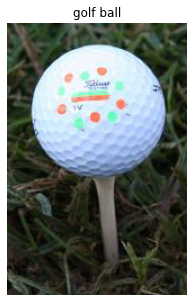

In [ ]:
dsets.show(dsets[0])

In [ ]:
item_tfms = [ToTensor, RandomResizedCrop(128, min_scale=0.35)]
batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]

Note that we have more transforms than in the data block API: there was no need to think of ToTensor or IntToFloatTensor there. This is because data blocks come with default item transforms and batch transforms when it concerns transforms you will always need with that type.

When passing those transforms to the .dataloaders method, the corresponding arguments have a slightly different name: the item_tfms are passed to after_item (because they are applied after the item has been formed) and the batch_tfms are passed to after_batch (because they are applied after the batch has been formed).

In [ ]:
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64, num_workers=8)

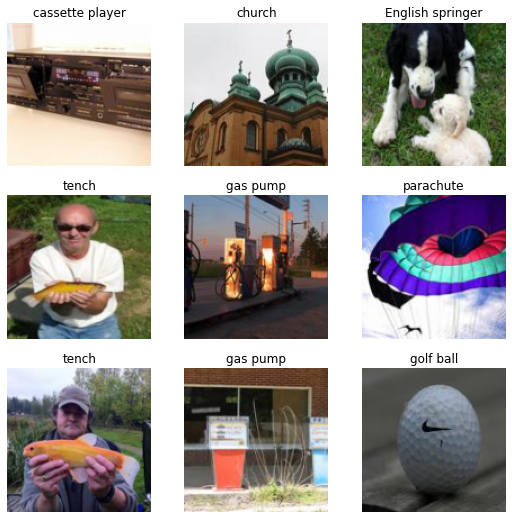

In [ ]:
dls.show_batch()

## Training a model from scratch

### Custom learner

In [ ]:
learn = vision_learner(dls, resnet34, metrics=accuracy, pretrained=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
learn.fit_one_cycle(5, 5e-3)

That’s a start. But since we are not using a pretrained model, why not use a different architecture? fastai comes with a version of the resnets models that have all the tricks from modern research incorporated. While there is no pretrained model using those at the time of writing this tutorial, we can certainly use them here. For this, we just need to use the Learner class. It takes our DataLoaders and a PyTorch model, at the minimum. Here we can use xresnet34 and since we have 10 classes, we specify n_out=10:

In [ ]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-3)

### Custom loss

The loss function you pass to a Learner is expected to take an output and target, then return the loss. It can be any regular PyTorch function and the training loop will work without any problem. What may cause problems is when you use fastai functions like Learner.get_preds, Learner.predict or Learner.show_results.

If you want Learner.get_preds to work with the argument with_loss=True (which is also used when you run ClassificationInterpretation.plot_top_losses for instance), your loss function will need a reduction attribute (or argument) that you can set to “none” (this is standard for all PyTorch loss functions or classes). With a reduction of “none”, the loss function does not return a single number (like a mean or sum) but something the same size as the target.

As for Learner.predict or Learner.show_results, they internally rely on two methods your loss function should have:

* if you have a loss that combines activation and loss function (such as nn.CrossEntropyLoss), an activation function.
* a decodes function that converts your predictions to the same format your targets are: for instance in the case of nn.CrossEntropyLoss, the decodes function should take the argmax.

As an example, let’s look at how to implement a custom loss function doing label smoothing (this is already in fastai as LabelSmoothingCrossEntropy).

In [ ]:
class LabelSmoothingCE(Module):
    def __init__(self, eps=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1) #We divide by that size at the return line so sum and not mean
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), reduction=self.reduction)

    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)

The forward pass implements the loss in itself. Note how the reduction arg determines how the final output is computed.

Then since this loss function combines activation (softmax) with the actual loss, we implement activation that take the softmax of the output. This is what will make Learner.get_preds or Learner.predict return the actual predictions instead of the final activations.

Lastly, decodes changes the outputs of the model to put them in the same format as the targets (one int for each sample in the batch size) by taking the argmax of the predictions. We can pass this loss function to Learner:

In [ ]:
learn = Learner(dls, xresnet34(n_out=10), loss_func=LabelSmoothingCE(), metrics=accuracy)

In [ ]:
learn.fit_one_cycle(5)

### Changing the optimizer

fastai uses its own class of Optimizer built with various callbacks to refactor common functionality and provide a unique naming of hyperparameters playing the same role (like momentum in SGD, which is the same as alpha in RMSProp and beta0 in Adam) which makes it easier to schedule them (such as in Learner.fit_one_cycle).

FastAI implements all optimizers available in PyTorch but if there e.g is one that is newly added you may need to implement it yourself. You can wrap a PT optimizer with OptimWrapper:

In [ ]:
pytorch_adamw = partial(OptimWrapper, opt=torch.optim.AdamW)

To implement different optimizers, we pass the **opt_func** our optimizer and parms_groups (a list of parameters)

In [ ]:
learn = Learner(
    dls, 
    xresnet18(n_out=10),
    lr = 1e-2,
    loss_func = LabelSmoothingCE(),
    metrics = accuracy,
    opt_func = partial(pytorch_adamw, weight_decay=0.01, eps=1e-3)
)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 5e-3)

### Changing the training loop with a callback

The base training loop in fastai is the same as PyTorch’s:



In [ ]:
'''
for xb, yb in dl:
  pred = model(xb)
  loss = loss_func(pred, yb)
  loss.backward()
  opt.step()
  opt.zero_grad()
'''

'\nfor xb, yb in dl:\n  pred = model(xb)\n  loss = loss_func(pred, yb)\n  loss.backward()\n  opt.step()\n  opt.zero_grad()\n'

where model, loss_func and opt are all attributes of our Learner. To easily allow you to add new behavior in that training loop without needing to rewrite it yourself (along with all the fastai pieces you might want like mixed precision, 1cycle schedule, distributed training…), you can customize what happens in the training loop by writing a callback.

* a Callback can read every piece of a Learner, hence knowing everything happening in the training loop
* a Callback can change any piece of the Learner, allowing it to alter the behavior of the training loop
* a Callback can even raise special exceptions that will allow breaking points (skipping a step, a validation phase, an epoch or even cancelling training entirely)

Here we will write a simple Callback applying mixup to our training (the version we will write is specific to our problem, use fastai’s MixUp in other settings).

Mixup consists in changing the inputs by mixing two different inputs and making a linear combination of them:

input = x1 * t + x2 * (1-t)

Where t is a random number between 0 and 1. Then, if the targets are one-hot encoded, we change the target to be

target = y1 * t + y2 * (1-t)

In practice though, targets are not one-hot encoded in PyTorch, but it’s equivalent to change the part of the loss dealing with y1 and y2 by

loss = loss_func(pred, y1) * t + loss_func(pred, y2) * (1-t)

because the loss function used is linear with respect to y.

We just need to use the version with reduction='none' of the loss to do this linear combination, then take the mean.

Here is how we could write a mixup in a callback:

In [ ]:
from torch.distributions.beta import Beta

In [ ]:
class Mixup(Callback):
  run_valid = False

  def __init__(self, alpha=0.4): self.distrib = Beta(tensor(alpha), tensor(alpha))
  
  def before_batch(self):
    self.t = self.distrib.sample((self.y.size(0),)).squeeze().to(self.x.device)
    shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
    x1, self.y1 = self.x[shuffle], self.y[shuffle]
    self.learn.xb = (x1 * (1-self.t[:,None,None,None]) + self.x * self.t[:,None,None,None],)

  def after_loss(self):
    with NoneReduce(self.loss_func) as lf:
      loss = lf(self.pred, self.y1) * (1-self.t) + lf(self.pred, self.y) * self.t
    self.learn.loss = loss.mean()

We can see we write two events:

* before_batch is executed just after drawing a batch and before the model is run on the input. We first draw our random numbers t, following a beta distribution (like advised in the paper) and get a shuffled version of the batch (instead of drawing a second version of the batch, we mix one batch with a shuffled version of itself). Then we set self.learn.xb to the new input, which will be the on fed to the model.
* after_loss is executed just after the loss is computed and before the backward pass. We replace self.learn.loss by the correct value. NoneReduce is a context manager that temporarily sets the reduction attribute of a loss to ‘none’.

Also, we tell the Callback it should not run during the validation phase with run_valid=False.


In [ ]:
learn = Learner(
    dls,
    xresnet18(n_out=10),
    lr = 2e-5,
    metrics = accuracy,
    loss_func = LabelSmoothingCE(),
    cbs = Mixup(),
    opt_func = partial(pytorch_adamw, weight_decay=0.01, eps=1e-3)
)

SuggestedLRs(valley=0.0003981071640737355)

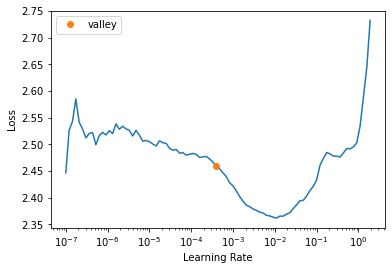

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 5e-3)

Exception ignored in: <finalize object at 0x7f8a65a65e00; dead>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/usr/lib/python3.7/tempfile.py", line 936, in _cleanup
    _rmtree(name)
  File "/usr/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: 'models/tmpziciz9yu'
Exception ignored in: <finalize object at 0x7f8a65a65e00; dead>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/usr/lib/python3.7/tempfile.py", line 936, in _cleanup
    _rmtree(name)
  File "/usr/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil

# Pets

Using Datasets, Pipeline, TfmdLists and Transform in computer vision:

* Transform to process the data
* Pipeline to composes transforms

Which both are just functions to process data. For datasets processing we will use:

* TfmdLists to apply one Pipline of Transforms on a collection of data
* Datasets to apply several Pipeline of Transforms on a collection of items in parallel and produce tuples

A rule of thumb is:

* Use TfmdLists when your Transforms will output the complete tuple (input, target)
* Use Datasets when you need to build separate Pipelines for each of your input(s) and target(s)

In [ ]:
from fastai.vision.all import *

## Processing data

Cleaning and processing data is one of the most time-consuming things in machine learning, which is why fastai tries to help you as much as it can. At its core, preparing the data for your model can be formalized as a sequence of transformations you apply to some raw items. For instance, in a classic image classification problem, we start with filenames. We have to open the corresponding images, resize them, convert them to tensors, maybe apply some kind of data augmentation, before we are ready to batch them. And that’s just for the inputs of our model, for the targets, we need to extract the label of our filename and convert it to an integer.

This process needs to be somewhat reversible, because we often want to inspect our data to double check what we feed the model actually makes sense. That’s why fastai represents all those operations by Transforms, which you can sometimes undo with a decode method.

In [ ]:
path = untar_data(URLs.MNIST_TINY)/'train'
fnames = get_image_files(path)
fn = fnames[0]; fn

### Transforms

Transform to open an image

In [ ]:
img = PILImage.create(fn); img

Transform to convert image to (c * h * w) tensor

In [ ]:
tconv = ToTensor()
img = tconv(img)
img.shape, type(img)

(torch.Size([3, 28, 28]), fastai.torch_core.TensorImage)

Transform to extract image text-label

In [ ]:
lbl = parent_label(fn); lbl

'3'

Transform to convert text-label to int label

In [ ]:
tcat = Categorize(vocab=['3','7'])
lbl = tcat(lbl); lbl

TensorCategory(0)

Using decode to reverse a Transform for demonstration purposes

In [ ]:
lbld = tcat.decode(lbl); lbld

'3'

### Pipeline

Pipeline for our image input

In [ ]:
pipe = Pipeline([PILImage.create, tconv])
img = pipe(fn); img.shape

torch.Size([3, 28, 28])

Our pipeline can decode and show an item

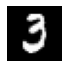

In [ ]:
pipe.show(img, figsize=(1,1), cmap='gray')

## Loading our dataset using only Transform

Let’s see how to use fastai.data to process the Pets dataset. If you are used to writing your own PyTorch Datasets, what will feel more natural is to write everything in one Transform. We use source to refer to the underlying source of our data (e.g. a directory on disk, a database connection, a network connection, etc). Then we grab the items.

In [ ]:
source = untar_data(URLs.PETS)/'images'
items = get_image_files(source)

We will need a function to covert our images to consistently sized tensors

In [ ]:
def resized_image(fn:Path, sz=128):
  x = Image.open(fn).convert('RGB').resize((sz,sz))
  return tensor(array(x)).permute(2,0,1).float()/255

If we want to be able to use the show method later on in our Pipeline, we need a type that knows how to show itself:

In [ ]:
class TitledImage(fastuple):
  def show(self, ctx=None, **kwargs): show_titled_image(self, ctx=ctx, **kwargs)

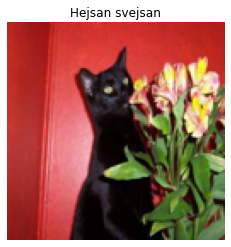

In [ ]:
img = resized_image(items[0])
TitledImage(img, 'Hejsan svejsan').show()

### Using decodes to show processed items

In [ ]:
class PetTfm(Transform):
  def __init__(self, vocab, obj2idx, labeller): self.vocab, self.obj2idx, self.labeller = vocab, obj2idx, labeller
  def encodes(self, obj): return [resized_image(obj), self.obj2idx[self.labeller(obj)]]
  def decodes(self, x): return TitledImage(x[0], self.vocab[x[1]])

In our Transform:
* encodes:
 * Opens our images, resizes them and converts them to normalized tensors
 * Labels our images with our labeler function and then converts those labels to indexes with our obj2idx function
* decodes:
  * Decodes the index that obj2idx gave us and returns the img (as is) and the decoded label

To use this Transform, we need a label function. Here we use a regex on the name attribute of our filenames:

In [ ]:
labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')

In [ ]:
doc(using_attr)

using_attr(f, attr)
Construct a function which applies `f` to the argument's attribute `attr`

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


Then we gather all possible labels, uniqueify them and ask for their two correspondences (vocab, obj2idx) using bidir=True. We can then use vocab and obj2idx to build our Transform.

In [ ]:
all_vals = list(map(labeller, items))
vocab, obj2idx = uniqueify(all_vals, sort=True, bidir=True)
pets = PetTfm(vocab, obj2idx, labeller)

x, y = pets(items[0])
decoded = pets.decode([x,y])

Encoded: torch.Size([3, 128, 128]) 3 

Decoded:


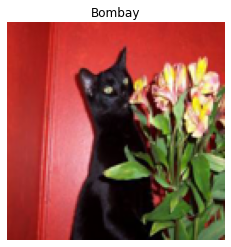

In [ ]:
print('Encoded:', x.shape, y, '\n')
print('Decoded:')
decoded.show()

Note that like __ call __ and encodes, we implemented a decodes method but we actually call decode on our Transform.

Also note that our decodes method received the two objects (x and y). We said in the previous section Transform dispatch over tuples (for the encoding as well as the decoding) but here it took our two elements as a whole and did not try to decode x and y separately. Why is that? It’s because we pass a list [x,y] to decodes. Transforms dispatch over tuples, but tuples only. And as we saw as well, to prevent a Transform from dispatching over a tuple, we just have to make it an ItemTransform:

In [ ]:
class PetTfm(ItemTransform):
  def __init__(self, vocab, obj2idx, labeller): self.vocab, self.obj2idx, self.labeller = vocab, obj2idx, labeller
  def encodes(self, obj): return (resized_image(obj), self.obj2idx[self.labeller(obj)])
  def decodes(self, x): return TitledImage(x[0], self.vocab[x[1]])

In [ ]:
all_vals = list(map(labeller, items))
vocab, obj2idx = uniqueify(all_vals, sort=True, bidir=True)
pets = PetTfm(vocab, obj2idx, labeller)

x, y = pets(items[0])
decoded = pets.decode((x,y))

Encoded: torch.Size([3, 128, 128]) 21 

Decoded:


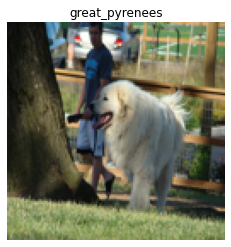

In [ ]:
print('Encoded:', x.shape, y, '\n')
print('Decoded:')
decoded.show()

### Setting up the internal state with a setups

We can now make our ItemTransform automatically infer its state from the data. This way, when we combine together our Transform with the data, it will automatically get setup without having to do anything. This is very easy to do: just copy the lines we had before to build the categories inside the transform in a setups method:

In [ ]:
class PetTfm(ItemTransform):
  def setups(self, items):
    self.labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')
    all_vals = list(map(labeller, items))
    self.vocab, self.obj2idx = uniqueify(all_vals, sort=True, bidir=True)

  def encodes(self, obj): return (resized_image(obj), self.obj2idx[self.labeller(obj)])
  def decodes(self, x): return TitledImage(x[0], self.vocab[x[1]])

Encoded: torch.Size([3, 128, 128]) 21

Decoded:


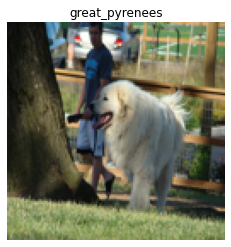

In [ ]:
pets = PetTfm()
pets.setups(items)
x,y = pets(items[0])
print('Encoded:', x.shape, y)
print('\nDecoded:')
pets.decodes((x,y)).show()


### Combining our transform with data augmentation in a Pipeline

We can take advantage of fastai’s data augmentation transforms if we give the right type to our elements. Instead of returning a standard PIL.Image, if our transform returns the fastai type PILImage, we can then use any fastai’s transform with it. Let’s just return a PILImage for our first element:

In [ ]:
class PetTfm(ItemTransform):
  def setups(self, items):
    self.labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')
    all_vals = list(map(labeller, items))
    self.vocab, self.obj2idx = uniqueify(all_vals, sort=True, bidir=True)

  def encodes(self, obj): return (PILImage.create(obj), self.obj2idx[self.labeller(obj)])
  def decodes(self, x): return TitledImage(x[0], self.vocab[x[1]])

We can then combine that transform with ToTensor, Resize or FlipItem to randomly flip our image in a Pipeline:

In [ ]:
tfms = Pipeline([PetTfm(), Resize(224), FlipItem(p=1), ToTensor()])

In [ ]:
tfms.setup(items)

In [ ]:
list(dir(tfms))[-10:], len(dir(tfms))

(['setup',
  'setups',
  'show',
  'size',
  'split_idx',
  'split_idx',
  'supports',
  'to_tensor',
  'train_setup',
  'vocab'],
 100)

To check the setup was done properly, we want to see if we did build the vocab. One cool trick of Pipeline is that when asking for an attribute, it will look through each of its Transforms for that attribute and give you the result (or the list of results if the attribute is in multiple transforms):

In [ ]:
tfms.vocab

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [ ]:
x,y = tfms(items[0])
x.shape,y

(torch.Size([3, 224, 224]), 21)

We can see ToTensor and Resize were applied to the first element of our tuple (which was of type PILImage) but not the second. We can even have a look at our element to check the flip was also applied:

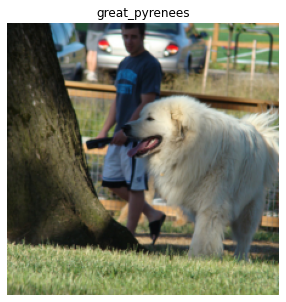

In [ ]:
tfms.show(tfms(items[0]))

Pipeline.show will call decode on each Transform until it gets a type that knows how to show itself. The library considers a tuple as knowing how to show itself if all its parts have a show method. Here it does not happen before reaching PetTfm since the second part of our tuple is an int. But after decoding the original PetTfm, we get a TitledImage which has a show method.

It’s a good point to note that the Transforms of the Pipeline are sorted by their internal order attribute (with a default of order=0). You can always check the order in which the transforms are in a Pipeline by looking at its representation:

In [ ]:
tfms

Pipeline: PetTfm -> FlipItem -- {'p': 1} -> Resize -- {'size': (224, 224), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor

In [ ]:
PetTfm.order, FlipItem.order, Resize.order, ToTensor.order

(0, 0, 1, 5)

To customize the order of a Transform, just set order = ... before the __init__ (it’s a class attribute). Let’s make PetTfm of order -5 to be sure it’s always run first:

In [ ]:
class PetTfm(ItemTransform):
  order = -5
  def setups(self, items):
    self.labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')
    all_vals = list(map(labeller, items))
    self.vocab, self.obj2idx = uniqueify(all_vals, sort=True, bidir=True)

  def encodes(self, obj): return (PILImage.create(obj), self.obj2idx[self.labeller(obj)])
  def decodes(self, x): return TitledImage(x[0], self.vocab[x[1]])

In [ ]:
tfms = Pipeline([FlipItem(p=1), PetTfm(), Resize(224), ToTensor()]) 

Even if we mess up the order, since we have specified PetTfm order = -5, it will still run first

In [ ]:
PetTfm.order, FlipItem.order, Resize.order, ToTensor.order

(-5, 0, 1, 5)

Now that we have a good Pipeline of transforms, let’s add it to a list of filenames to build our dataset. A Pipeline combined with a collection is a TfmdLists in fastai.

## TfmdLists and Datasets

The main difference between TfmdLists and Datasets is the number of Pipelines you have: TfmdLists take one Pipeline to transform a list (like we currently have) whereas Datasets combines several Pipelines in parallel to create a tuple from one set of raw items, for instance a tuple (input, target).

Creating a TfmdLists just requires a list of items and a list of transforms that will be combined in a Pipeline:

### One Pipeline makes a TfmdLists

In [ ]:
tls = TfmdLists(items, [PetTfm(), Resize(224), FlipItem(p=1), ToTensor()])
x, y = tls[0]; x.shape, y

(torch.Size([3, 224, 224]), 21)

We did not need to pass anything to PetTfm thanks to our setup method: the Pipeline was automatically setup on the items during the initialization, so PetTfm has created its vocab like before:

In [ ]:
tls.vocab

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

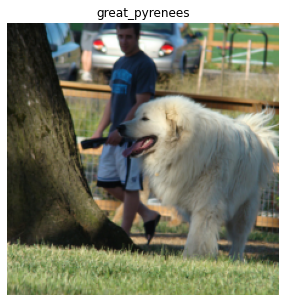

In [ ]:
tls.show(tls[0])

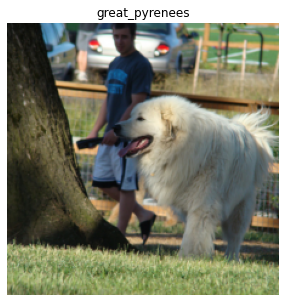

In [ ]:
show_at(tls, 0)

### Training and validation set

TfmdLists has an ‘s’ in its name because it can represent several transformed lists: your training and validation sets. To use that functionality, we just need to pass splits to the initialization. splits should be a list of lists of indices (one list per set). To help create splits, we can use all the splitters of the fastai library:

In [ ]:
splits = RandomSplitter(seed=42)(items); splits

((#5912) [5643,5317,5806,3460,613,5456,2968,3741,10,4908...],
 (#1478) [4512,4290,5770,706,2200,4320,6450,501,1290,6435...])

In [ ]:
tls = TfmdLists(items, [PetTfm(), Resize(224), FlipItem(p=1), ToTensor()], splits=splits)

This populates TfmdLists valid set (it had one before the split but all items were in the train set)

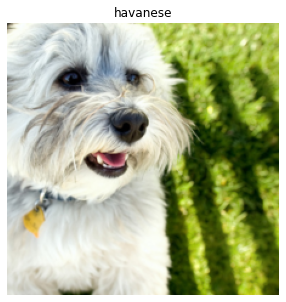

In [ ]:
show_at(tls.train, 0)

An interesting thing is that unless you pass train_setup=False, your transforms are setup on the training set only (which is best practices): the items received by setups are just the elements of the training set.

### Getting to DataLoaders

From a TfmdLists, getting a DataLoaders object is very easy, you just have to call the dataloaders method:

In [ ]:
dls = tls.dataloaders(bs=64)

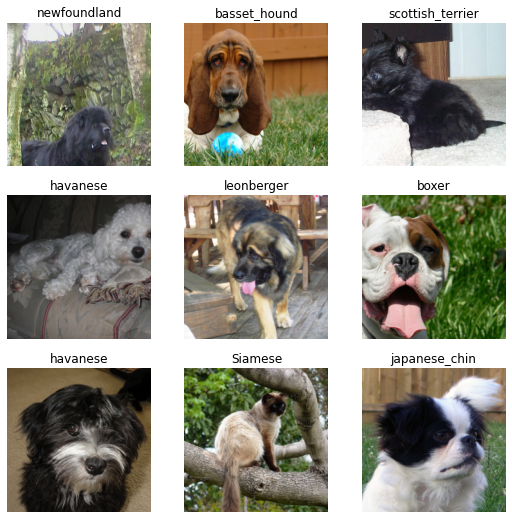

In [ ]:
dls.show_batch()

You can even add augmentation transforms, since we have a proper fastai typed image. Just remember to add the IntToFloatTensor transform that deals with the conversion of int to float (augmentation transforms of fastai on the GPU require float tensors). When calling TfmdLists.dataloaders, you pass the batch_tfms to after_batch (and potential new item_tfms to after_item):

In [ ]:
dls = tls.dataloaders(bs=64, after_batch=[IntToFloatTensor(), *aug_transforms()])


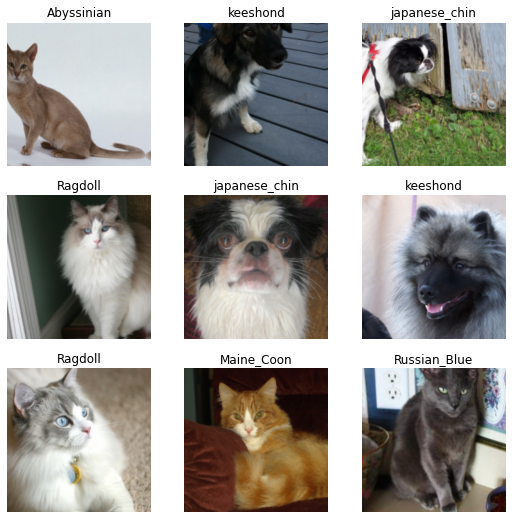

In [ ]:
dls.show_batch()

### Using Datasets

Datasets applies a list of list of transforms (or list of Pipelines) lazily to items of a collection, creating one output per list of transforms/Pipeline. This makes it easier for us to separate out steps of a process, so that we can re-use them and modify the process more easily. This is what lays the foundation of the data block API: we can easily mix and match types as inputs or outputs as they are associated to certain pipelines of transforms.

For instance, let’s write our own ImageResizer transform with two different implementations for images or masks:

In [ ]:
class ImageResizer(Transform):
  order = 1
  "Resize image to size using resample"
  def __init__(self, size, resample = BILINEAR):
    if not is_listy(size): size = (size, size)
    self.size, self.resample = (size[1], size[0]), resample

  def encodes(self, obj:PILImage): return obj.resize(size = self.size, resample = self.resample)
  def encodes(self, obj:PILMask): return obj.resize(size = self.size, resample = NEAREST)

Specifying the type-annotations makes it so that our transform does nothing to things that are neither PILImage or PILMask, and resize images with self.resample, masks with the nearest neighbor interpolation. To create a Datasets, we then pass two pipelines of transforms, one for the input and one for the target:

In [ ]:
tfms = [
    [PILImage.create, ImageResizer(128), ToTensor(), IntToFloatTensor()],
    [labeller, Categorize()]
]

dsets = Datasets(items, tfms)

In [ ]:
i = dsets[0]
type(i[0]), type(i[1])

(fastai.torch_core.TensorImage, fastai.torch_core.TensorCategory)

torch.Size([3, 128, 128]) great_pyrenees


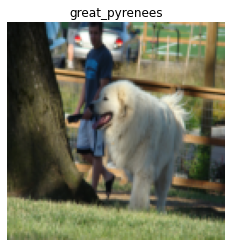

In [ ]:
x,y = dsets.decode(i)
print(x.shape, y)
dsets.show(i);

And we can pass our train/validation split like in TfmdLists:



In [ ]:
dsets = Datasets(items, tfms, splits=splits)

But we are not using the fact that Transforms dispatch over tuples here. ImageResizer, ToTensor and IntToFloatTensor could be passed as transforms over the tuple. This is done in .dataloaders by passing them to after_item. They won’t do anything to the category but will only be applied to the inputs.

In [ ]:
tfms = [[PILImage.create], [labeller, Categorize()]]
dsets = Datasets(items, tfms, splits=splits)
dls = dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

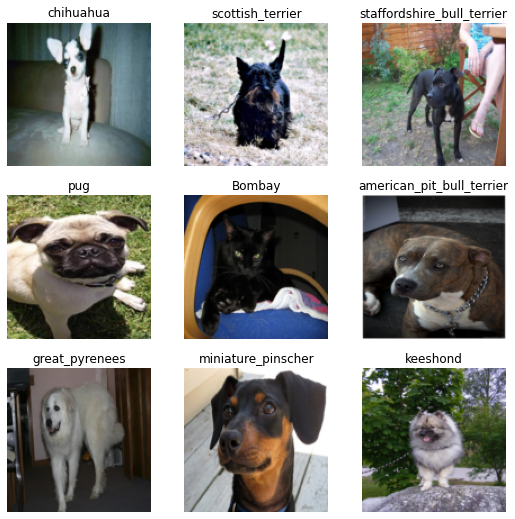

In [ ]:
dls.show_batch()

If we just wanted to build one DataLoader from our Datasets (or the previous TfmdLists), you can pass it directly to TfmdDL:

In [ ]:
dsets = Datasets(items, tfms)
dl = TfmdDL(dsets, bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

### Segmentation

By using the same transforms in after_item but a different kind of targets (here segmentation masks), the targets are automatically processed as they should with the type-dispatch system.

In [ ]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
cv_split = RandomSplitter(seed=42)(cv_items)
cv_labels = lambda obj: cv_source/f'labels/{obj.stem}_P{obj.suffix}'

In [ ]:
tfms = [[PILImage.create], [cv_labels, PILMask.create]]

In [ ]:
dsets = Datasets(cv_items, tfms, splits=cv_split)

(96, 128) PILMask mode=L size=128x96


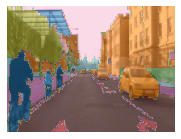

In [ ]:
x,y = dsets.decode(dsets[0])
print(x.shape, y)
dsets.show(dsets[0]);

In [ ]:
dls = dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

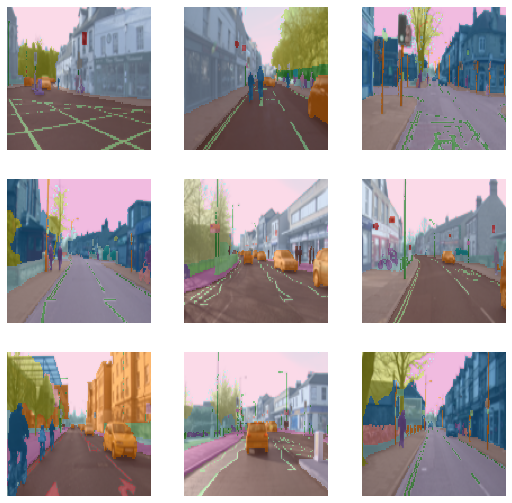

In [ ]:
dls.show_batch()

## Adding a test dataloader for inference

From the old dataloaders:

In [ ]:
source = untar_data(URLs.PETS)
items = get_image_files(source/'images')

In [ ]:
labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')
splits = RandomSplitter(seed=42)(items)

In [ ]:
tfms = [[PILImage.create], [labeller, Categorize()]]
dsets = Datasets(items, tfms, splits=splits)
dls = dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

Imagine we have some new items to classify:

In [ ]:
source = untar_data(URLs.PETS)
tst_files = get_image_files(source/'images')

In [ ]:
len(tst_files)

7390

We can create a dataloader that takes those files and applies the same transforms as the validation set with DataLoaders.test_dl:

In [ ]:
tst_dl = dls.test_dl(tst_files)

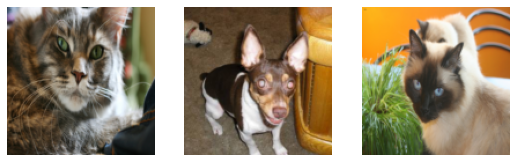

In [ ]:
tst_dl.show_batch(max_n=3)

Note:

You can call learn.get_preds passing this newly created dataloaders to make predictions on our new images!
What is really cool is that after you finished training your model, you can save it with learn.export, this is also going to save all the transforms that need to be applied to your data. In inference time you just need to load your learner with load_learner and you can immediately create a dataloader with test_dl to use it to generate new predictions!